# Adaptive Tracking Simulation Example

## Setup

In [217]:
from datetime import datetime, timedelta
start_time = datetime.now()

## Radar system

In [218]:
from mpar_sim.radar import PhasedArrayRadar
from mpar_sim.beam.beam import RectangularBeam, GaussianBeam
from mpar_sim.looks.look import Look
from mpar_sim.resource_management import PAPResourceManager
from mpar_sim.schedulers import BestFirstScheduler
import numpy as np

radar = PhasedArrayRadar(
    position=np.array([[0], [0], [0]]),
    position_mapping=(0, 2, 4),
    rotation_offset=np.array([[0], [0], [0]]),
    # Array parameters
    n_elements_x=32,
    n_elements_y=32,
    element_spacing=0.5,  # Wavelengths
    element_tx_power=10,
    # System parameters
    center_frequency=3e9,
    system_temperature=290,
    noise_figure=4,
    # Scan settings
    beam_shape=RectangularBeam,
    az_fov=[-45, 45],
    el_fov=[-45, 45],
    # Detection settings
    false_alarm_rate=1e-6,
)
radar.timestamp = start_time

manager = PAPResourceManager(radar,
                             max_duty_cycle=0.1,
                             max_bandwidth=100e6)
scheduler = BestFirstScheduler(manager,
                               sort_key="start_time",
                               reverse_sort=False,
                               max_time_delta=timedelta(seconds=2))


Raster scan agent

In [219]:
from mpar_sim.agents.raster_scan import RasterScanAgent
import numpy as np

search_agent = RasterScanAgent(
    azimuth_scan_limits=np.array([-30, 30]),
    elevation_scan_limits=np.array([-5, 5]),
    azimuth_beam_spacing=0.8,
    elevation_beam_spacing=0.8,
    azimuth_beamwidth=20,
    elevation_beamwidth=20,
    bandwidth=100e6,
    pulsewidth=1e-6,
    prf=5e3,
    n_pulses=10,
)

## Tracker Components

Create tracker

In [220]:
from stonesoup.measures import Mahalanobis, Euclidean
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.updater.kalman import ExtendedKalmanUpdater
from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
from stonesoup.gater.distance import DistanceGater

# KF prediction model. Assuming it's matched to the true target model for now
transition_model = CombinedLinearGaussianTransitionModel([
    ConstantVelocity(10),
    ConstantVelocity(10),
    ConstantVelocity(0.0),
])
predictor = KalmanPredictor(transition_model)

updater = ExtendedKalmanUpdater(measurement_model=None)

hypothesizer = DistanceHypothesiser(
    predictor, updater, measure=Mahalanobis(), missed_distance=50)

Create the data associator

In [221]:
from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
associator = GNNWith2DAssignment(hypothesizer)

Create the deleter

In [222]:
from stonesoup.deleter.time import UpdateTimeStepsDeleter, UpdateTimeDeleter
from stonesoup.deleter.error import CovarianceBasedDeleter
from stonesoup.deleter.multi import CompositeDeleter
covar_deleter = CovarianceBasedDeleter(covar_trace_thresh=30)
time_deleter = UpdateTimeStepsDeleter(5)
deleter = CompositeDeleter([covar_deleter, time_deleter], delete_last_pred=True, intersect=True)

Create the initiator

In [223]:
from stonesoup.types.state import GaussianState
from stonesoup.initiator.simple import MultiMeasurementInitiator, SimpleMeasurementInitiator
import numpy as np
from mpar_sim.initiator.initators import MofNInitiator


initiator = MofNInitiator(
    prior_state=GaussianState([0, 0, 0, 0, 0, 0], np.diag([0, 0, 0, 0, 0, 0])),
    measurement_model=None,
    deleter=deleter,
    associator=associator,
    updater=updater,
    confirmation_threshold=[3,5],
)

Tracking agent

In [224]:
from mpar_sim.agents.track_while_scan import TWSAgent
from mpar_sim.agents.adaptive_track import AdaptiveTrackAgent
from mpar_sim.beam.common import aperture2beamwidth

track_agent = AdaptiveTrackAgent(
    initiator,
    associator,
    predictor,
    updater,
    deleter,
    # Adaptive track parameters
    track_sharpness=0.15,
    min_revisit_rate=2,
    max_revisit_rate=10,
    confirm_rate=20,
    # Task parameters
    azimuth_beamwidth=3,
    elevation_beamwidth=3,
    bandwidth=100e6,
    pulsewidth=10e-6,
    prf=5e3,
    n_pulses=100
)

# track_agent = TWSAgent(initiator, associator, updater, deleter)


## Metric generators

In [225]:
from stonesoup.metricgenerator.basicmetrics import BasicMetrics
from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics
from stonesoup.metricgenerator.manager import SimpleManager
from stonesoup.dataassociator.tracktotrack import TrackToTruth
from stonesoup.measures import Euclidean

basic_generator = BasicMetrics()
siap_generator = SIAPMetrics(position_measure=Euclidean((0, 2, 4)),
                             velocity_measure=Euclidean((1, 3, 5)))
measure_associator = TrackToTruth(association_threshold=30)
metric_manager = SimpleManager([basic_generator, siap_generator],
                               associator=measure_associator)


## Run the simulation

In [226]:
import copy
import operator
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.types.array import CovarianceMatrix
from stonesoup.types.state import StateVector
import random
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from mpar_sim.simulator.simple import MultiTargetScenario

# Set the simulation seed
seed = np.random.randint(0, 2**32-1)

# Simulation-level parameters
include_noise = True

# Target generation parameters
initial_state_mean = StateVector([1000, 10, 0, 0, 0, 0])
initial_state_covariance = CovarianceMatrix(np.diag([200, 50, 400, 10, 0, 0]))
initial_state = GaussianState(
    initial_state_mean, initial_state_covariance, timestamp=start_time)
target_rcs = 1

scenario = MultiTargetScenario(
    transition_model=transition_model,
    initial_state=initial_state,
    timestep=timedelta(seconds=0),
    number_steps=1000,
    birth_rate=0.0,
    death_probability=0.0,
    seed=seed,
    initial_number_targets=10,
)


truths = []
all_truths = set()
confirmed_tracks = set()
tentative_tracks = set()
all_measurements = []
all_tracks = set()

# Simulation time variables.
time = start_time
scheduler_time = start_time
for time, truths in scenario:
  
  ########################################
  # Simulate the current look
  ########################################
  if manager.allocated_tasks:
    look = manager.allocated_tasks.pop()
    scheduler_time = look.end_time
    radar.load_look(look)
    if look.start_time > time:
      # Interpolate targets to the start of the look
      current_truths = []
      dt = look.start_time - time
      for truth in current_truths:
        if radar.is_detectable(truth[-1]):
          state = GroundTruthState(
              transition_model.function(truth[-1],
                                        noise=False,
                                        time_interval=dt),
              timestamp=look.start_time)
          state.rcs = target_rcs
          truth = GroundTruthPath([state])
          current_truths.append(truth)
    else:
      for truth in truths:
        truth.states[-1].rcs = target_rcs
      current_truths = truths
    all_truths |= truths
    detections = radar.measure(current_truths, noise=include_noise)

    # Update tracks
    confirmed_tracks = track_agent.update_tracks(detections, look.start_time)

    # Update metrics
    all_measurements.append(detections)
    all_tracks |= confirmed_tracks
    metric_manager.add_data(
        truths, confirmed_tracks, detections,
        overwrite=False
    )

  ########################################
  # Allocate resources
  ########################################
  # Generate looks from each agent
  search_looks = []
  search_looks.append(search_agent.act(current_time=scheduler_time))
  track_looks = track_agent.act(current_time=scheduler_time)

  looks = search_looks + track_looks

  # Schedule new looks, sorted so that the task with the nearest end time is selected first below
  scheduler.schedule(looks, scheduler_time)
  manager.allocated_tasks.sort(
      key=operator.attrgetter("end_time"), reverse=True)

  ########################################
  # Update scenario
  ########################################
  # Minimum start time of all scheduled tasks. When this changes, a new "batch" of tasks has been allocated and the scenario needs to be updated
  min_start_time = min([task.start_time for task in manager.allocated_tasks]
                       ) if manager.allocated_tasks else time

  scenario.timestep = min_start_time - time


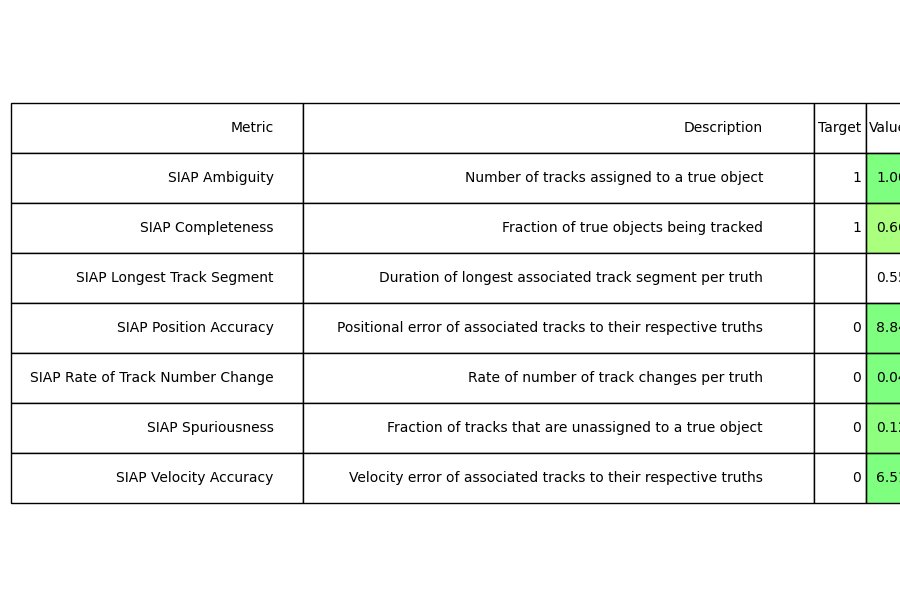

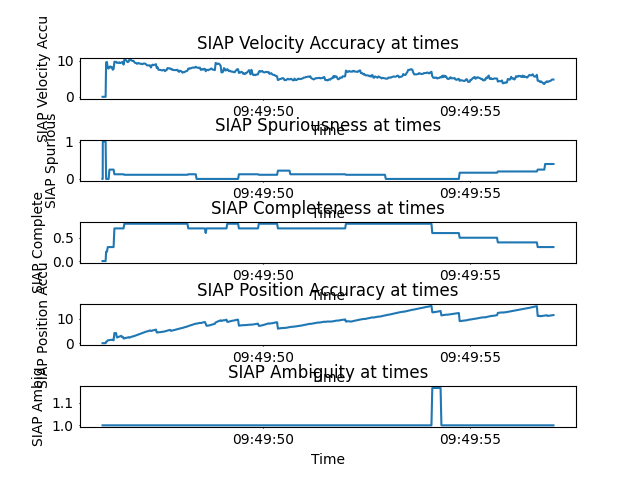

In [227]:
%matplotlib widget
from stonesoup.metricgenerator.metrictables import SIAPTableGenerator
import matplotlib.pyplot as plt

metrics = metric_manager.generate_metrics()
siap_averages = {metrics.get(metric) for metric in metrics
                 if metric.startswith("SIAP") and not metric.endswith(" at times")}
siap_time_based = {metrics.get(metric) for metric in metrics if metric.endswith(' at times')}

_ = SIAPTableGenerator(siap_averages).compute_metric()

fig2, axes = plt.subplots(5)

fig2.subplots_adjust(hspace=1)

t_siaps = siap_time_based

times = metric_manager.list_timestamps()

for siap, axis in zip(t_siaps, axes):
    siap_type = siap.title[:-13]  # remove the ' at timestamp' part
    axis.set(title=siap.title, xlabel='Time', ylabel=siap_type)
    axis.tick_params(length=1)
    axis.plot(times, [t_siap.value for t_siap in siap.value])
    
# plt.show()

## Plot simulation results

In [228]:
from stonesoup.plotter import Plotterly

plotter = Plotterly()
plotter.plot_sensors(radar, "Radar")
plotter.plot_ground_truths(all_truths, [0, 2])
plotter.plot_measurements(all_measurements, [0, 2])
plotter.plot_tracks(all_tracks, [0,2])
plotter.fig




